### Install the dependencies

In [ ]:
%pip install --quiet sonar-space seaborn pandas

### We first instantiate text pipelines that'll load sonar text encoder and decoder models (it'll take ~ 30 seconds)

In [3]:
import torch

from sonar.inference_pipelines.text import (
    TextToEmbeddingModelPipeline,
    TextToTextModelPipeline,
)

In [4]:
text2vec = TextToEmbeddingModelPipeline(
    encoder="text_sonar_basic_encoder", tokenizer="text_sonar_basic_encoder"
)
text2text = TextToTextModelPipeline(
    encoder="text_sonar_basic_encoder",
    decoder="text_sonar_basic_decoder",
    tokenizer="text_sonar_basic_encoder",
)  # tokenizer is attached to both encoder and decoder cards

### Let's compute the cosine-similarity between sonar embeddings of english and french sentences.

> We present text and audio samples borrowed from the FLEURS dataset. The FLEURS dataset is licensed under the [Creative Commons license (CC-BY).](https://creativecommons.org/licenses/). You can access the FLEURS paper at https://arxiv.org/abs/2205.12446.

In [7]:
# shorted examples from FLORES dataset
english_sentences = [
    "He died in Osaka on Tuesday.",
    "No one was inside the apartment.",
    "Zayat was unhurt in the accident.",
    "\"Some may not agree but I don't care.",
    "He documented himself in a 1998 book.",
    "An inquiry was established to investigate.",
    "Then Whirling Dervishes took to the stage.",
    "In Berlin, police estimated 6,500 protestors.",
    "He joined them in 1945 and stayed until 1958.",
    "It is the biggest acquisition in eBay's history.",
    '"We were all simply in shock," the mother stated.',
    "Unwanted murals or scribble is known as graffiti.",
    "Seven points behind, Johnson is second with 2,243.",
    "When the official arrived, the apartment exploded.",
    "A Hangi Meal is cooked in a hot pit in the ground.",
]

french_sentences = [
    "Il est mort à Osaka mardi.",
    "Personne n'était à l'intérieur de l'appartement.",
    "Zayat est sorti indemne de l'accident.",
    "«\xa0Certains ne seront peut-être pas d'accord, mais cela m'est égal.",
    "Il a fait des recherches dans un livre paru en 1998.",
    "Une enquête a été ouverte.",
    "Puis les derviches tourneurs sont montés sur scène.",
    "À Berlin, la police estime qu'il y avait environ 6 500 manifestants.",
    "Il le rejoint en 1945 et y reste jusqu'en 1958.",
    "C’est la plus grande acquisition de l’histoire d’eBay.",
    "« Nous étions tous simplement sous le choc », a déclaré la mère.",
    "Les peintures murales ou les gribouillages indésirables sont connus sous le nom de graffitis.",
    "Sept points de retard, Johnson est deuxième avec 2243 points.",
    "Une fois l'agent arrivé sur place, l'appartement a explosé.",
    "On cuit un repas hangi dans une fosse chaude creusée dans le sol.",
]

In [9]:
output_eng = text2vec.predict(english_sentences, source_lang="eng_Latn")
embed_english_sentence = torch.nn.functional.normalize(output_eng, dim=-1).numpy()

In [10]:
output_fr = text2vec.predict(french_sentences, source_lang="fra_Latn")
embed_french_sentence = torch.nn.functional.normalize(output_fr, dim=-1).numpy()

<Axes: >

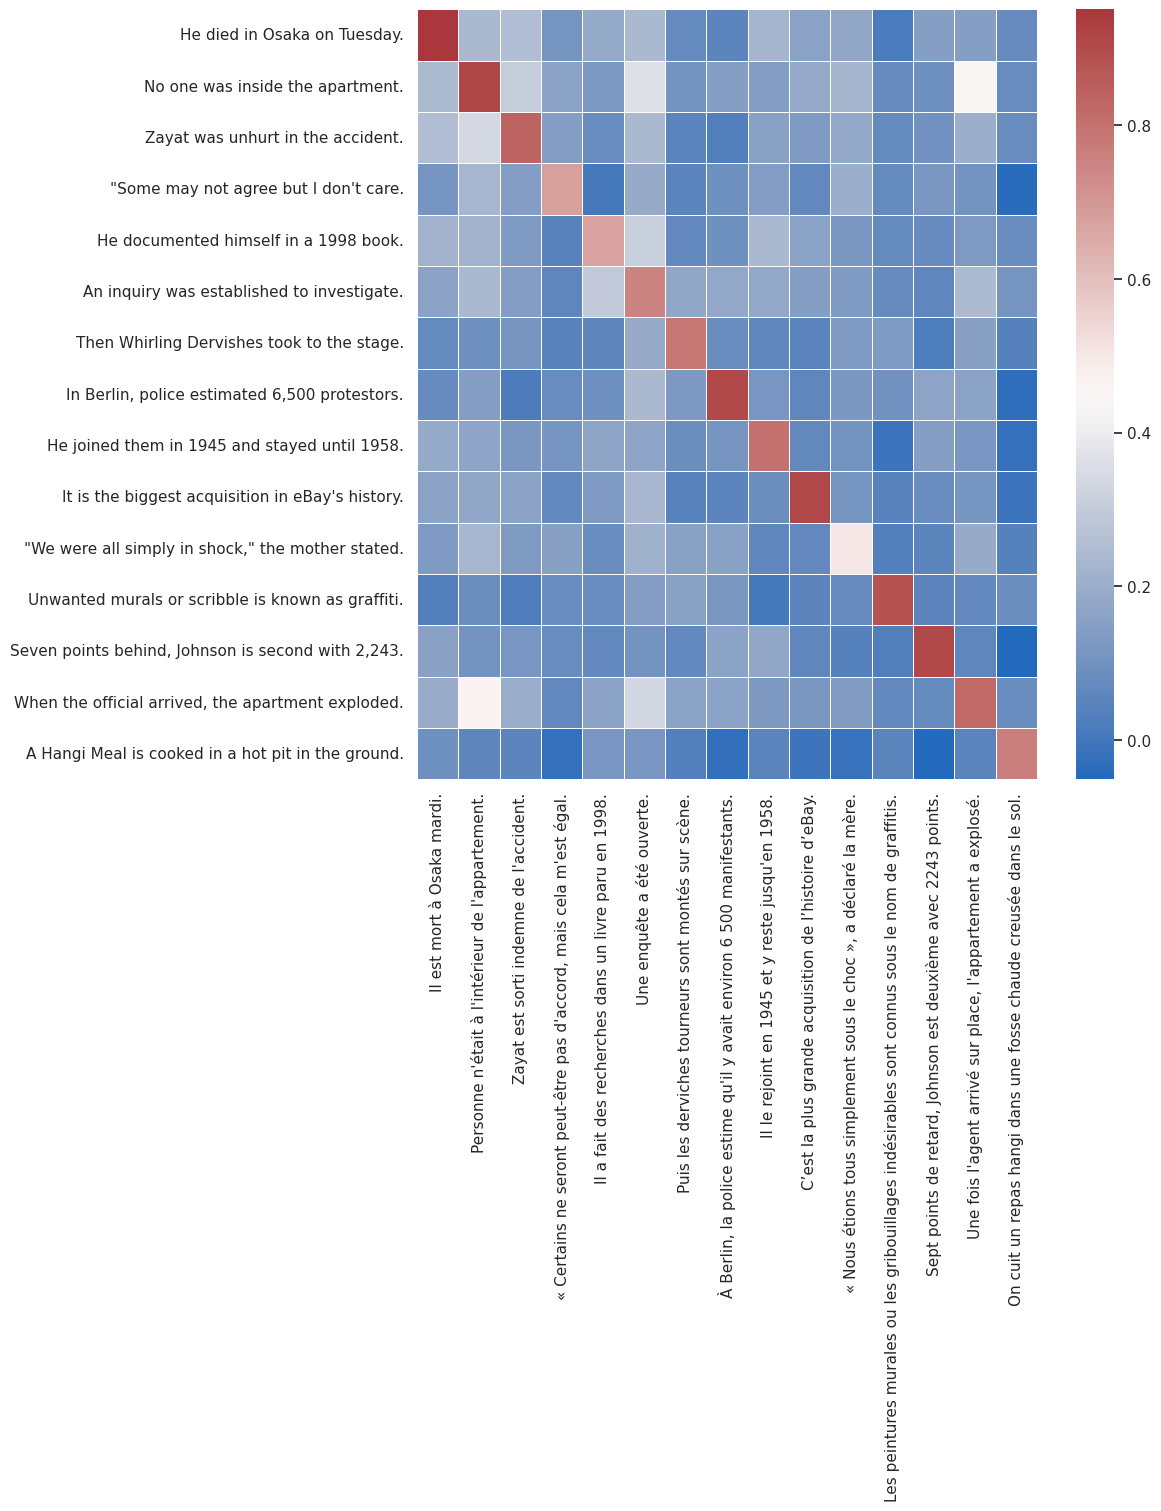

In [11]:
#!pip install seaborn pandas
import pandas as pd
import seaborn as sns

cos_sim = embed_english_sentence.dot(embed_french_sentence.T)
sim_df = pd.DataFrame(cos_sim, columns=french_sentences, index=english_sentences)
sns.set(font_scale=0.8)
sns.set(rc={"figure.figsize": (10, 10)})
sns.heatmap(sim_df, cmap="vlag", linewidths=0.5)

### We may also perform a translation and compute BLEU score.

In [13]:
french_translated_sentences = text2text.predict(
    english_sentences, source_lang="eng_Latn", target_lang="fra_Latn"
)

english_translated_sentences = text2text.predict(
    french_sentences, source_lang="fra_Latn", target_lang="eng_Latn"
)

In [14]:
import sacrebleu

bleu_obj = sacrebleu.corpus_bleu(
    french_translated_sentences, [french_sentences], tokenize="flores200"
)
print("*" * 120)
print("english to french translation bleu score :")
print(bleu_obj)

bleu_obj = sacrebleu.corpus_bleu(
    english_translated_sentences, [english_sentences], tokenize="flores200"
)
print("*" * 120)
print("french to english translation bleu score :")
print(bleu_obj)

Tokenizer 'spm' has been changed to 'flores101', and may be removed in the future.
Tokenizer 'spm' has been changed to 'flores101', and may be removed in the future.


************************************************************************************************************************
english to spanish translation bleu score :
BLEU = 43.58 69.1/52.2/41.1/32.0 (BP = 0.934 ratio = 0.936 hyp_len = 220 ref_len = 235)
************************************************************************************************************************
spanish to english translation bleu score :
BLEU = 42.33 67.2/48.1/35.4/28.0 (BP = 1.000 ratio = 1.054 hyp_len = 177 ref_len = 168)
